- In this kernel I will provide all the steps required for doing time series analysis using time series data and simple RNN, LSTM models.
- You can see the performance of simple RNN model, LSTM model and compare their performance.

## 1. Basic step

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

#check all the files in the input dataset
print(os.listdir("../input/"))

['FE_hourly.csv', 'NI_hourly.csv', 'DOM_hourly.csv', 'est_hourly.paruqet', 'PJMW_hourly.csv', 'COMED_hourly.csv', 'EKPC_hourly.csv', 'PJME_hourly.csv', 'DEOK_hourly.csv', 'DAYTON_hourly.csv', 'DUQ_hourly.csv', 'PJM_Load_hourly.csv', 'pjm_hourly_est.csv', 'AEP_hourly.csv']


Using TensorFlow backend.


## 2. Data loading and data exploration

- **Load the data file**

In [2]:
#choosing DOM_hourly.csv data for analysis
fpath='../input/DOM_hourly.csv'

df=pd.read_csv(fpath)
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


- **Change the index of rows in the dataframe from 0,1,2... to datetime (2005-12-31 01:00:00,...)**

**Why should we change the index of rows?**<br>
Because we are dealing with time series data and we will need the datetime data to recognize a particular record.

In [3]:
#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


- **Check if there are missing values in the data loaded**

In [4]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

Since there is no missing data in the data loaded we will not be dropping the missing value records or will not be imputing the data. We will proceed with the further data analysis.

- **Data visualization**

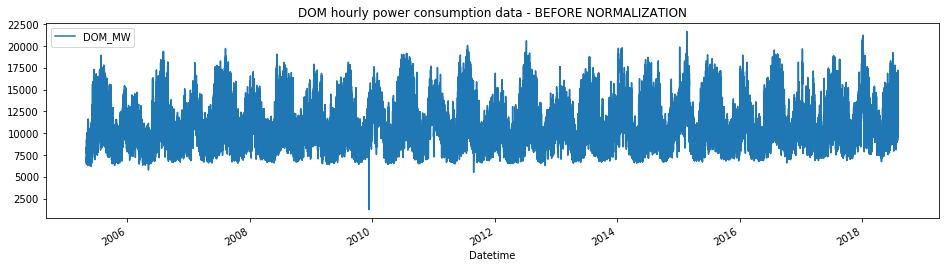

In [5]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

- **Normalize data**
- Before proceeding with further data analysis we must ensure that the data is normalized. 
- For this we will be using [sklearn MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [6]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

- **Visualize data after normalization**
- After normalization the range of power consumption values changes which we can observe on the **y-axis** of the graph. In the earlier graph that was displayed it was in the range **0 - 22500**
- Now after normalization we can observe that the data range on **y-axis** is **0.0 - 1.0**

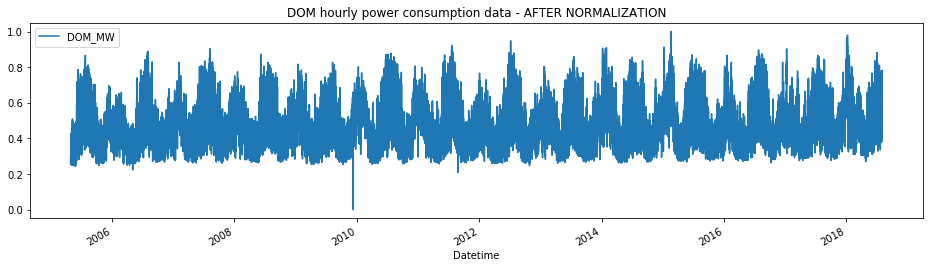

In [7]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [8]:
df_norm.shape

(116189, 1)

## 3. Prepare data for training the RNN models

In [9]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

**To get an understanding on how sequence length is useful in training RNN models refer to the following links:**
- https://stackoverflow.com/questions/49573242/what-is-sequence-length-in-lstm
- https://stats.stackexchange.com/questions/158834/what-is-a-feasible-sequence-length-for-an-rnn-to-model

In [10]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


## 4. Build a SIMPLE RNN model

In [11]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_3 (Dropout)  

In [12]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
110000/110000 [==============================] - 5s 46us/step - loss: 0.1207
Epoch 2/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0270
Epoch 3/10
110000/110000 [==============================] - 3s 32us/step - loss: 0.0144
Epoch 4/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0095
Epoch 5/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0072
Epoch 6/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0057
Epoch 7/10
110000/110000 [==============================] - 3s 30us/step - loss: 0.0048
Epoch 8/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0041
Epoch 9/10
110000/110000 [==============================] - 3s 31us/step - loss: 0.0036
Epoch 10/10
110000/110000 [==============================] - 4s 33us/step - loss: 0.0031


- **Let's check r2 score for the values predicted by the above trained SIMPLE RNN model**
- For more info on r2 score refer [this](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [13]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9451304414415442


- **Let's compare the actual values vs predicted values by plotting a graph**
- We see that the predcited values are close to the actual values meaning the RNN model is performing well in predicting the sequence.

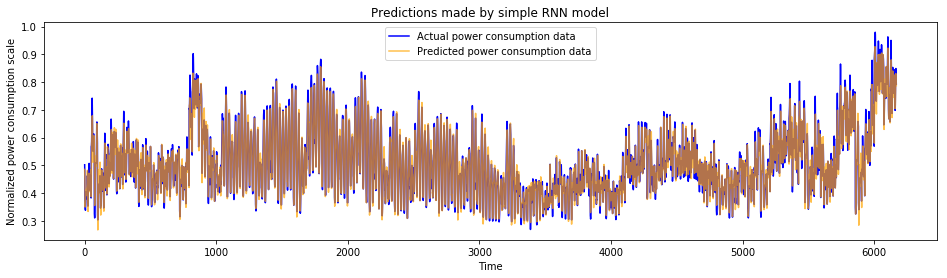

In [14]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

## 5. Build an LSTM model

In [15]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total para

In [16]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110000/110000 [==============================] - 11s 103us/step - loss: 0.0216
Epoch 2/10
110000/110000 [==============================] - 9s 85us/step - loss: 0.0115
Epoch 3/10
110000/110000 [==============================] - 9s 85us/step - loss: 0.0091
Epoch 4/10
110000/110000 [==============================] - 9s 85us/step - loss: 0.0052
Epoch 5/10
110000/110000 [==============================] - 9s 84us/step - loss: 0.0041
Epoch 6/10
110000/110000 [==============================] - 9s 85us/step - loss: 0.0033
Epoch 7/10
110000/110000 [==============================] - 9s 84us/step - loss: 0.0027
Epoch 8/10
110000/110000 [==============================] - 10s 89us/step - loss: 0.0023
Epoch 9/10
110000/110000 [==============================] - 10s 91us/step - loss: 0.0020
Epoch 10/10
110000/110000 [==============================] - 10s 87us/step - loss: 0.0018


- **Let's check r2 score for the values predicted by the above trained LSTM model**

In [17]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9537783301840462


- **Let's compare the actual values vs predicted values by plotting a graph**

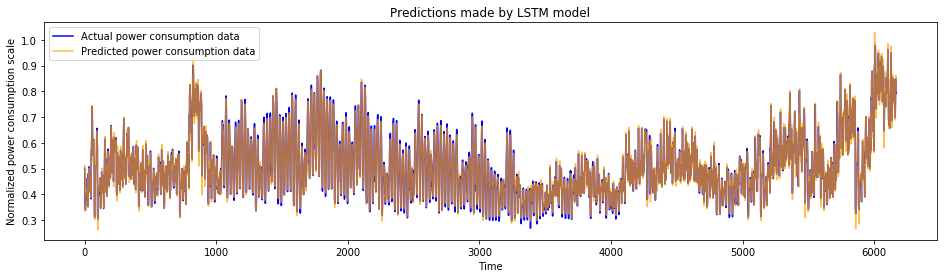

In [18]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

## 6. Compare predictions made by simple RNN, LSTM model by plotting data in a single graph

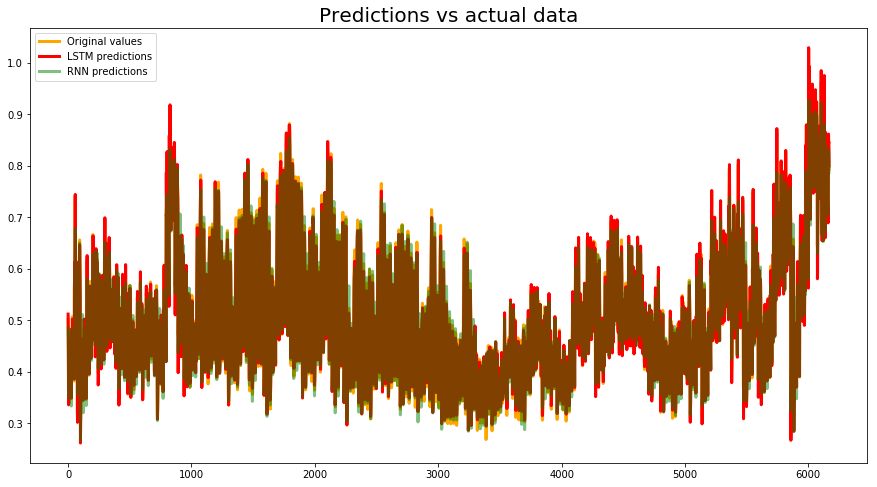

In [19]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

**References:**
- https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru